In [25]:
#Import required libraries

import numpy as np
import phate as ph
import pandas as pd
import matplotlib.pyplot as plt



In [26]:
#Load the dataset

import gzip
import numpy as np

def extract_and_read(filename):
    with gzip.open(filename, 'rb') as f:
        data = f.read()
    return data

def read_idx(data):
    # Read magic number
    magic = data[:4]
    # Read number of items
    num_items = int.from_bytes(data[4:8], byteorder='big')
    
    if magic == b'\x00\x00\x08\x03': # for images
        num_rows = int.from_bytes(data[8:12], byteorder='big')
        num_cols = int.from_bytes(data[12:16], byteorder='big')
        # Read data
        data = np.frombuffer(data[16:], dtype=np.uint8).reshape(num_items, num_rows, num_cols)
    elif magic == b'\x00\x00\x08\x01': # for labels
        # Read data
        data = np.frombuffer(data[8:], dtype=np.uint8)
    else:
        raise ValueError("Invalid magic number")
        
    return data

# Filenames of the zip files
filenames = {
    'train-images': 'Data/train-images-idx3-ubyte.gz',
    'train-labels': 'Data/train-labels-idx1-ubyte.gz',
    'test-images': 'Data/t10k-images-idx3-ubyte.gz',
    'test-labels': 'Data/t10k-labels-idx1-ubyte.gz'
}

# Read data
data = {}
for key, filename in filenames.items():
    with open(filename, 'rb') as f:
        data[key] = extract_and_read(filename)

# Parse and extract data
train_images = read_idx(data['train-images'])
train_labels = read_idx(data['train-labels'])
test_images = read_idx(data['test-images'])
test_labels = read_idx(data['test-labels'])

# Example usage
print("Training images shape:", train_images.shape)
print("Training labels shape:", train_labels.shape)
print("Test images shape:", test_images.shape)
print("Test labels shape:", test_labels.shape)



Training images shape: (60000, 28, 28)
Training labels shape: (60000,)
Test images shape: (10000, 28, 28)
Test labels shape: (10000,)


In [27]:
#Section A) Run rate on the train datasets without labels? 

train_images_reshape = train_images.reshape((train_images.shape[0],train_images.shape[1]*train_images.shape[2]))

n = 10000 #subset of points because phate takes a long time to run
train_features = train_images_reshape[:n,:]

phate_operator = ph.PHATE()
phate_embedding = phate_operator.fit_transform(train_features)

embedding1 = phate_embedding

#Get t from VNE
t_vne = phate_operator.optimal_t

t_values = [t_vne-1,t_vne+1]

#get new imbedding
phate_operator.set_params(t=t_values[0])
embedding2 = phate_operator.fit_transform(train_features)

phate_operator.set_params(t=t_values[1])
embedding3 = phate_operator.fit_transform(train_features)

embedding_array = [embedding1,embedding2,embedding3]


Calculating PHATE...
  Running PHATE on 10000 observations and 784 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 0.93 seconds.
    Calculating KNN search...
    Calculated KNN search in 8.22 seconds.
    Calculating affinities...
    Calculated affinities in 0.05 seconds.
  Calculated graph and diffusion operator in 9.21 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 0.62 seconds.
    Calculating KMeans...
    Calculated KMeans in 1.87 seconds.
  Calculated landmark operator in 3.17 seconds.
  Calculating optimal t...
    Automatically selected t = 24
  Calculated optimal t in 1.18 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.31 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 3.54 seconds.
Calculated PHATE in 17.41 seconds.
Calculating PHATE...
  Running PHATE on 10000 observations and 784 variables.
  Calculating graph and diffusion o

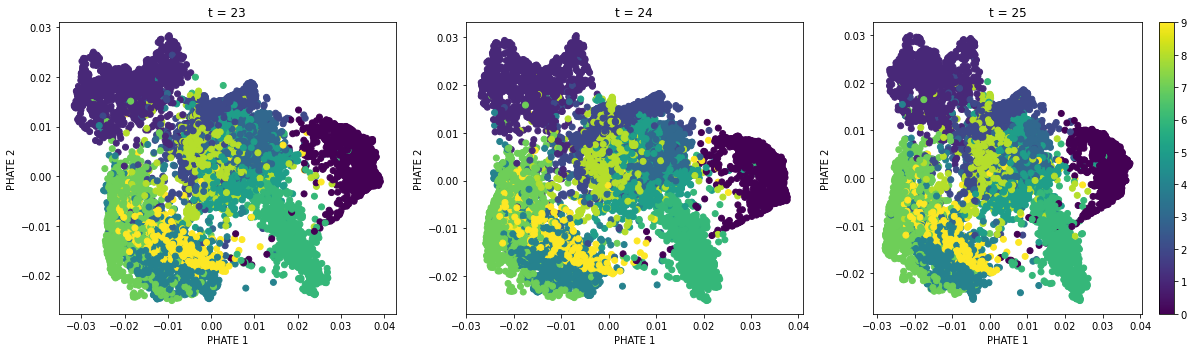

In [29]:

t_list = [t_vne-1,t_vne,t_vne+1]

fig, axs = plt.subplots(1, len(embedding_array), figsize=(17, 5))

for i, embedding in enumerate(embedding_array):
    scatter = axs[i].scatter(embedding[:, 0], embedding[:, 1], c=train_labels[:n], cmap='viridis')
    axs[i].set_title(f"t = {t_list[i]}")
    axs[i].set_xlabel("PHATE 1")
    axs[i].set_ylabel("PHATE 2")
fig.colorbar(scatter,ax=axs[2],orientation='vertical')
plt.tight_layout()
plt.savefig('Figures/Problem4_partA.png',dpi=200)